# Sales Forecasting with Facebook Prophet
## Sales Projections using Historical Data

**Author**: Miguel Santana

Thank you for reviewing this repository. The author's contact info, blog post, sources and social media profiles are listed below under **further information.**

The contents of this repository detail an analysis of product sales using regression and time series analysis. Our focus will be on leveraging Facebook Prophet's time series forecasting tools through additive regression. The analysis will provide insight into an unknown company's product sales for over 1000 stores with respect to features like store operations, holidays, promotions and customers.  

#### Project Framework | OSEMN

**Data processing and analysis is completed using the OSEMN framework. The structure includes: Obtaining the data, Scrubbing (processing), Exploratory Data Analysis, Statistical Modeling and Interpretation of the Results.**

#### The Data

The dataset was provided by Udemy. The Udemy citation is available below under **sources.** 

**Feature Key:**
* ID: Transaction ID
* Store: Store ID
* Sales: Sales per Day in Euros (Target)
* Customers: Customers per Day
* Open: Store Opened or Closed (Day)
* Promo: Running Promotion per Day 
* StateHoliday:
    * a: Public holiday
    * b: Easter
    * c: Christmas
    * 0: None
* SchoolHoliday: ID store affected by school closure

**Feature Key 2:**
* Store Type: a, b, c, d
* Assortment: basic(a), extra(b), extended(c)
* CompetitionDistance: distance to closest competitor in meters
* CompetitionOpenSince: date when competitor was open [Month/Year]
* Promo2: Continuing/Consecutive Promotion
* Promo2Since: date of promo 2 start
* PromoInterval: ID consecutive promo 2 intervals

#### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

In [31]:
# modeling and evaluating
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Import Data
#### Sales Data

In [4]:
# sales data
df_sales = pd.read_csv('train.csv')

print(df_sales.shape)
print('\n')
df_sales.head(2)

(1017209, 9)




,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


#### Store Data

In [5]:
# store level data
df_stores = pd.read_csv('store.csv')

print(df_stores.shape)
print('\n')
df_stores.head(2)

(1115, 10)




,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [6]:
print(f'The data includes {len(df_sales)} sales transactions across {len(df_stores)} stores.')

The data includes 1017209 sales transactions across 1115 stores.


# Scrubbing | Data Cleaning
### Null Values
#### Sales Nulls

In [7]:
df_sales.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

#### Store Nulls

In [8]:
print(f'There are {len(df_stores)} total stores in our analysis.') 
df_stores.isnull().sum()

There are 1115 total stores in our analysis.


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

<div class="alert alert-success">

The competitor and promo 2 column nulls match up exactly leading me to believe that these corresponding stores have no competitor or promo 2 values that are applicable. As such, they will be filled with zero. The columns in question are: **CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear and PromoInterval** which corresponds directly to promo 2 activity.

</div>

In [9]:
storecols = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
             'Promo2SinceWeek','Promo2SinceYear','PromoInterval']
for col in storecols:
    df_stores[col] = df_stores[col].fillna(0)

In [10]:
# filling in last 3 null values with averages
df_stores['CompetitionDistance'].fillna(df_stores['CompetitionDistance'].mean(),inplace=True)

### Closed Stores

In [11]:
closedstores = df_sales[df_sales['Open']==0]
openstores = df_sales[df_sales['Open']==1]

print('Total open stores', len(openstores))
print('Total closed stores', len(closedstores))

Total open stores 844392
Total closed stores 172817


In [12]:
# removing closed stores
df_sales = df_sales[df_sales['Open']==1]

In [13]:
# drop open column - redundant info
df_sales.drop(['Open'],axis=1,inplace=True)

<div class="alert alert-success">

These values were removed because the promo, customer and sales values from closed stores were effecting the overall analysis.

</div>

### Feature Engineering | Date Time Extractions

In [14]:
df_sales['Year'] = pd.DatetimeIndex(df_sales['Date']).year
df_sales['Month'] = pd.DatetimeIndex(df_sales['Date']).month
df_sales['Day'] = pd.DatetimeIndex(df_sales['Date']).day

### Merging Data Frames
#### Using the Store ID

In [15]:
df = pd.merge(df_sales,df_stores,how='inner',on='Store')

# Exploratory Data Analysis
### Correlation to Target

In [16]:
df.corr()['Sales'].sort_values(ascending=False)

Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
Month                        0.073600
SchoolHoliday                0.038617
Year                         0.036169
Store                        0.007710
CompetitionOpenSinceYear     0.005266
CompetitionOpenSinceMonth   -0.018370
CompetitionDistance         -0.036343
Day                         -0.051849
Promo2SinceWeek             -0.058476
Promo2                      -0.127596
Promo2SinceYear             -0.127621
DayOfWeek                   -0.178736
Name: Sales, dtype: float64

## Feature Relationships | Sales Distribution
#### Monthly Sales Trends

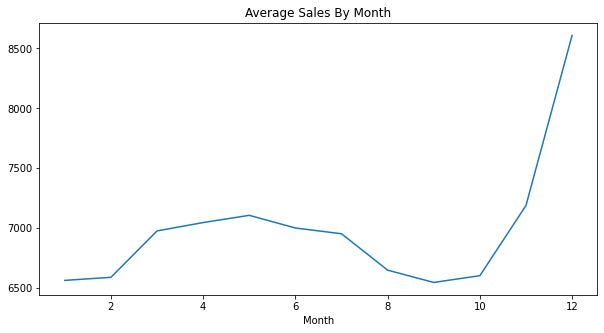

In [17]:
# Sales by month
df.groupby('Month')['Sales'].mean().plot(figsize=(10,5),title='Average Sales By Month');
# plt.savefig('salesXmonth.jpg',dpi=200,bbox_inches='tight')

<div class="alert alert-success">

There is an uptrend in sales during the summer months followed by the largest increase in sales occurring during the winter months (around the black Friday and Christmas season).

</div>

#### Daily Sales Trends

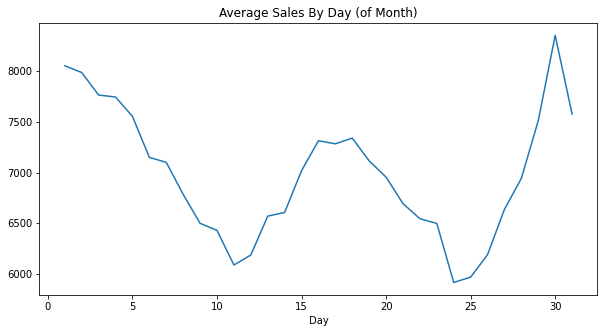

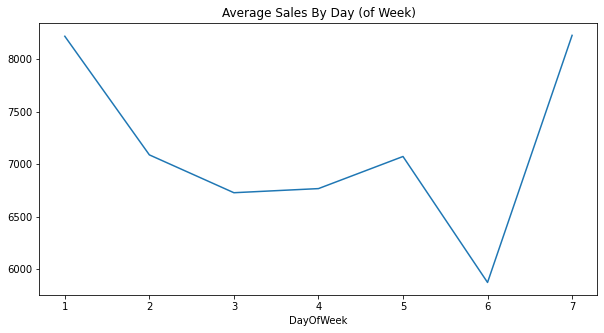

In [18]:
# Customers by Day/Month
df.groupby('Day')['Sales'].mean().plot(figsize=(10,5),title='Average Sales By Day (of Month)');
# plt.savefig('salesXdom.jpg',dpi=200,bbox_inches='tight')
plt.show()
# # Customers by Day/Week
df.groupby('DayOfWeek')['Sales'].mean().plot(figsize=(10,5),title='Average Sales By Day (of Week)');
# plt.savefig('salesXdow.jpg',dpi=200,bbox_inches='tight')

</div>

<div class="alert alert-success">

There are three prominent sales peaks per month:
* 1) First few days of the month
* 2) From the 15th-20th
* 3) On the last day of the month

Of those days; Monday and Sunday reflect the highest number of average daily sales. 

</div>

## Identifying the Top Performing Stores

In [19]:
top = df.groupby('Store')['Sales','CompetitionDistance','Promo2'].mean().sort_values(by='Sales',ascending=False).head(10).reset_index()

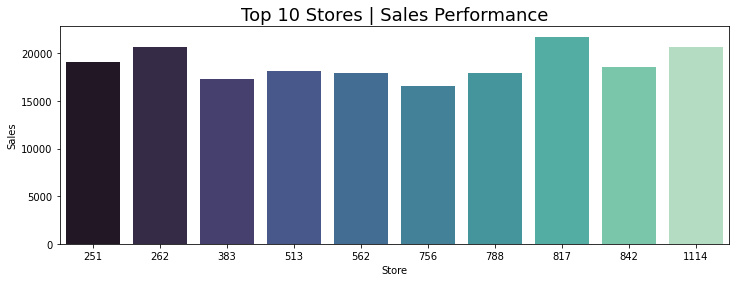

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='Store',y='Sales',data=top,palette='mako');
plt.title('Top 10 Stores | Sales Performance', size=18)
plt.show()
# fig.savefig('top10Xsales.jpg',dpi=200,bbox_inches='tight')

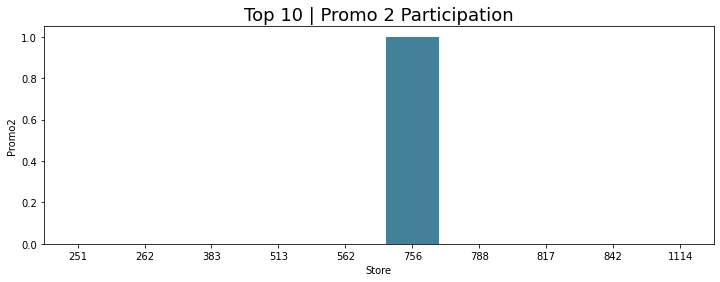

In [21]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='Store',y='Promo2',data=top,palette='mako');
plt.title('Top 10 | Promo 2 Participation', size=18)
plt.show()
# fig.savefig('promo2part.jpg',dpi=200,bbox_inches='tight')

In [22]:
avgcomp_dist = df['CompetitionDistance'].mean()
topcomp_dist = top['CompetitionDistance'].mean()
avgpromo2 = df['Promo2'].mean()
toppromo2 = top['Promo2'].mean()

In [23]:
print(f'The average distance of a competitor to a store is {round(avgcomp_dist,2)}.')
print(f'The average competitor distance to a top 10 store is {topcomp_dist}.')
print('\n')
print(f'Promo 2 | {round(avgpromo2,2)*100} percent of stores participate in promotion two.')
print(f'Promo 2 | {toppromo2*100} percent of top 10 stores participate in promotion two.')

The average distance of a competitor to a store is 5457.84.
The average competitor distance to a top 10 store is 727.0.


Promo 2 | 50.0 percent of stores participate in promotion two.
Promo 2 | 10.0 percent of top 10 stores participate in promotion two.


<div class="alert alert-success">

Store 817 has the highest average sales. To our surprise, only 1 of the top 10 stores participates in promotion two. In addition, the top 10 stores are substantially closer to competitors when compared to the average distance of competition. 

</div>

## Model Preparation
#### Preparing School and State Holidays

In [24]:
# numpy arrays of state and school related holidays
school_holidays = df[df['SchoolHoliday']==1].loc[:,'Date'].values

state_holidays = df[(df['StateHoliday'] == 'a') | 
                    (df['StateHoliday'] == 'b') | 
                    (df['StateHoliday'] == 'c')].loc[:,'Date'].values

In [25]:
# converting the values to data frames
state_holidays = pd.DataFrame({'ds' : pd.to_datetime(state_holidays), 
                               'holiday' : 'state_holiday'})

school_holidays = pd.DataFrame({'ds' : pd.to_datetime(school_holidays), 
                                'holiday' : 'school_holiday'})

In [26]:
# concat data frames
school_state_holidays = pd.concat((state_holidays,school_holidays)) # top to bottom

#### Converting Data Frame for Analysis

In [27]:
def sales_prep(Store_ID, sales_df):
    '''make predictions per store, for how long'''
    sales_df = sales_df[sales_df['Store'] == Store_ID] # extract data related to specific store
    sales_df = sales_df[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})# rename date and sales
    sales_df = sales_df.sort_values('ds') # sort sales in ascending order
    return sales_df

#### Store Selection

In [32]:
# store number 817 / 6
storedf = sales_prep(817, df)

# Statistical Modeling | Facebook Prophet

In [33]:
# model object / fit model
model = Prophet(holidays=school_state_holidays,daily_seasonality=True) # instantiate
model.fit(storedf) # fit
# forecast
future = model.make_future_dataframe(periods=30) # 30 days
forecast = model.predict(future)

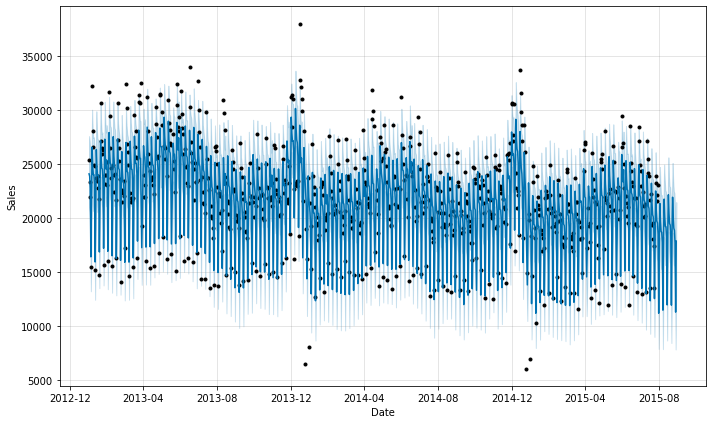

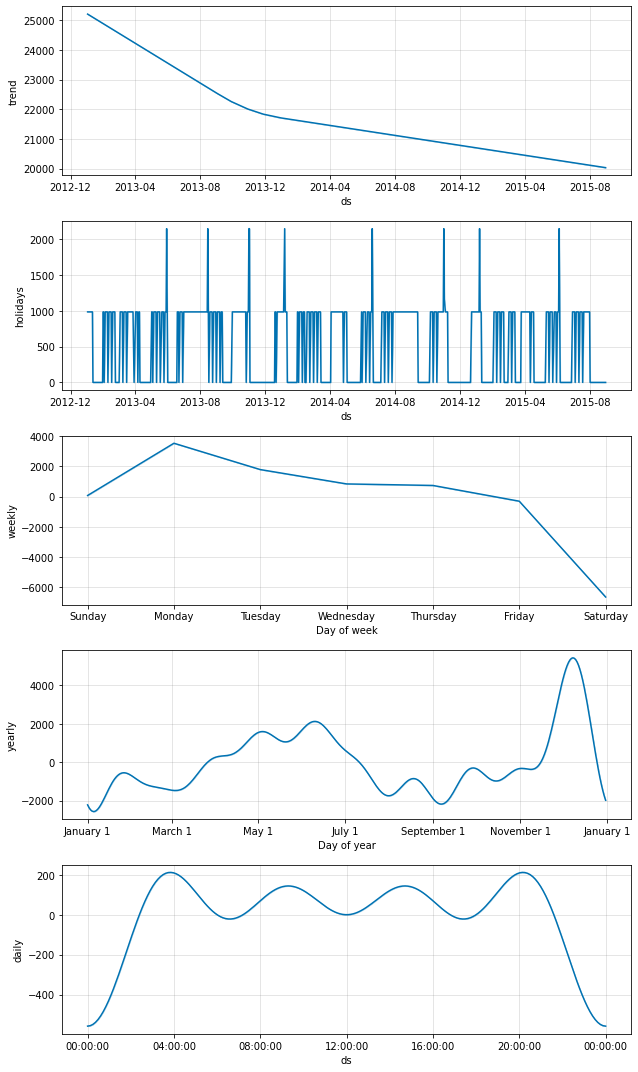

In [34]:
figure = model.plot(forecast,xlabel='Date',ylabel='Sales')
figure2 = model.plot_components(forecast)

### Evaluating Performance | Cross Validation

In [35]:
# facebook prophet's cross validation
df_cv = cross_validation(model,initial='400 days',period='400 days',horizon='45 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-12 00:00:00 and 2015-06-16 00:00:00


In [41]:
metrics = performance_metrics(df_cv)
avgmape = metrics['mape'].mean()
avgrmse = metrics['rmse'].mean()
print(f'The average MAPE is {round(avgmape,3)*100} percent.')
print(f'The average RMSE is {round(avgrmse,3)}.')
metrics

The average MAPE is 7.8 percent.
The average RMSE is 2025.914.


,horizon,mse,rmse,mae,mape,coverage
0,4 days,5.777925e+06,2403.731381,2206.233792,0.107166,1.000000
1,5 days,5.285253e+06,2298.967718,2088.165656,0.109013,1.000000
2,6 days,5.160700e+06,2271.717401,2085.906893,0.108191,1.000000
3,7 days,5.897657e+06,2428.509145,2241.944496,0.110804,1.000000
4,8 days,4.448390e+06,2109.120716,1796.164158,0.087594,1.000000
5,9 days,4.174872e+06,2043.250370,1734.212689,0.077161,1.000000
6,10 days,2.035693e+06,1426.777123,1072.095334,0.048758,1.000000
7,11 days,6.230824e+05,789.355704,637.813399,0.032158,1.000000
8,12 days,6.155616e+05,784.577322,632.394771,0.033477,1.000000
9,13 days,2.732347e+06,1652.981202,1032.320876,0.045211,0.857143


<div class="alert alert-success">

Cross validation shows our mean average percentage error typically under or around the 10 percent mark with an average of 7.8%. The root mean squared error is acceptable when considering the average sales for store 817 being 21,757.

</div> 

#### Plotting Residuals

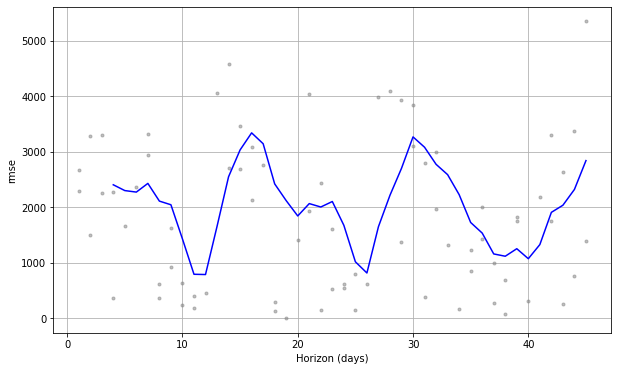

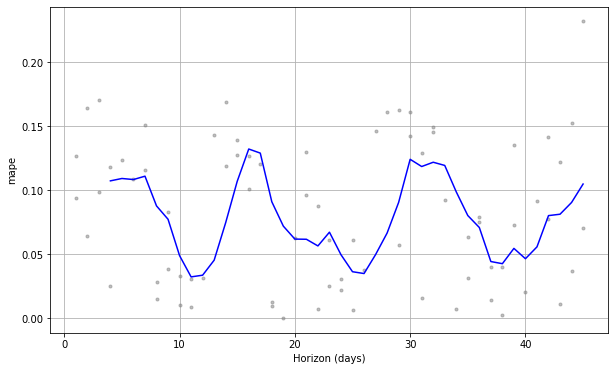

In [37]:
# root mean squared error / plotting residuals
plot_cross_validation_metric(df_cv,metric='rmse');
# plotting mean absolute percentage error
plot_cross_validation_metric(df_cv,metric='mape');

<div class="alert alert-success">

While there aren't many direct features that can be used to infer effects on our target variable with respect to business growth, it's important to note that the top performing stores are located near competitors. In addition, almost all of the top stores did not participate in promotion two. 

</div> 

## Results, Limitations and Future Work

The model was able to predict sales for store 817 with an average percentage error of 7.8 percent. Our predictions show a decline in sales over the next 30 days but end short of the expected uptick in traffic that occurs over the holiday season (November and December). 

#### Limitations
The analysis is limited by the anonymity of the data. Per the source, the company is based in Europe and many external factors may influence sales including customer cultural preferences. Additionally, product knowledge is not available and features of the product itself may be influencing the analysis. 

#### Recommendations
While our analysis is limited, its worth noting that the top store is near competitors and is not participating in the second-extended promotion that is made available to approximately half of the stores in our dataset. With limited domain knowledge, a recommendation would include removing promotion two from bottom performing stores so they may focus on advertising traditional company wide promotions. In addition, the existence of competition with respect to the customer and product sold should be considered when opening new stores. 

#### Future Work
Future work should include additional store level data such as employees in store, online sales, product information and geographic information to consider additional external factors through feature engineering. 

#### Further Information

For any additional questions, please reach out via email at santana2.miguel@gmail.com, on [LinkedIn](https://www.linkedin.com/in/miguel-angel-santana-ii-mba-51467276/) or on [Twitter.](https://twitter.com/msantana_ds)

#### Sources

Additional analysis, notes and file sources can be found on Udemy's website. 

* Course Name: Data Science for Business by Ryan Ahmed